# Figure 3

In [11]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [12]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# RNAseq directory
dir_rna = '/home/louiscam/projects/gpcr/data/bulk_rnaseq/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Directpry of TF target data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [13]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load gene data

In [14]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc['geneLength'] = df_loc['chromEnd']-df_loc['chromStart']
genes_df = df_loc[['geneSymbol', 'geneLength']].set_index('geneSymbol')

In [15]:
# Active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))
# Active/inactive genes
active_genes = pickle.load(open(saving_dir+'active_genes.pkl','rb'))
inactive_genes = pickle.load(open(saving_dir+'inactive_genes.pkl','rb'))

In [16]:
# Adhesome genes
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl','rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl','rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))
all_adhesome_genes = np.concatenate([active_adhesome_genes,inactive_adhesome_genes])

In [17]:
# TF genes
active_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'active_lung_adhesome_tf_genes.pkl','rb'))

In [18]:
# Mapping gene to chromosome
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl', 'rb'))

# Breakdown of TFs

In [19]:
# Load data
htargettf_df = pd.read_csv(dir_htftarget+'hTFtarget.txt', sep='\t', header=0)
htargettf_df['adhesome target'] = htargettf_df['target'].isin(all_adhesome_genes)
htargettf_df['active TF'] = htargettf_df['TF'].isin(active_genes)
htargettf_df['active target'] = htargettf_df['target'].isin(active_genes)
htargettf_df['active adhesome target'] = htargettf_df['target'].isin(active_adhesome_genes)
htargettf_df['lung'] = htargettf_df['tissue'].str.contains('lung')
htargettf_df = htargettf_df[['TF','active TF','target','active target',
                             'adhesome target','active adhesome target',
                             'tissue','lung']]
lung_tfs = htargettf_df[htargettf_df['lung']==True]['TF'].unique()
adhesome_lung_tfs = htargettf_df[(htargettf_df['lung']==True) & (htargettf_df['active adhesome target']==True)]['TF'].unique()
print('Number of unique TFs = '+str(len(np.unique(htargettf_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_df)))

Number of unique TFs = 495
Number of unique targets = 38183
Number of TF-target links = 1342129


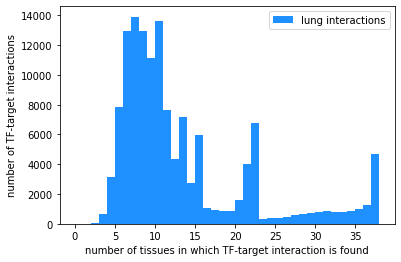

In [20]:
# Histogram of number of tissues in which interactions are found for lung TFs
z_lung = [len(tissue.split(',')) 
          for tissue in htargettf_df['tissue'].unique() if ('lung' in tissue)]
plt.figure()
plt.hist(z_lung, bins=np.arange(0,max(z_lung)+1,1), color='dodgerblue', label='lung interactions')
plt.xlabel('number of tissues in which TF-target interaction is found')
plt.ylabel('number of TF-target interactions')
plt.legend(loc='upper right')
plt.show()

In [21]:
# Select only lung TF-target links
htargettf_lung_df = htargettf_df[htargettf_df['lung']==True]
print('Number of unique TFs = '+str(len(np.unique(htargettf_lung_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_lung_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_lung_df)))

Number of unique TFs = 76
Number of unique targets = 32734
Number of TF-target links = 253173


In [22]:
# Select only lung TF-target links with active adhesome targets
htargettf_lung_adh_df = htargettf_df[(htargettf_df['lung']==True) & (htargettf_df['active adhesome target']==True)]
print('Number of unique TFs = '+str(len(np.unique(htargettf_lung_adh_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_lung_adh_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_lung_adh_df)))

Number of unique TFs = 58
Number of unique targets = 195
Number of TF-target links = 2924


In [23]:
# Annotation
cat = []
cat_id = []
for i in tqdm(range(htargettf_df.shape[0])):
    if htargettf_df['lung'].iloc[i]==False:
        cat.append('non-lung TFs')
        cat_id.append(3)
    elif htargettf_df['active adhesome target'].iloc[i]==False:
        cat.append('other lung TFs')
        cat_id.append(2)
    else:
        cat.append('lung TFs targeting active adhesome')
        cat_id.append(1)
htargettf_df['category'] = cat
htargettf_df['category_id'] = cat_id

100%|██████████| 1342129/1342129 [00:14<00:00, 90607.57it/s] 


<Figure size 432x288 with 0 Axes>

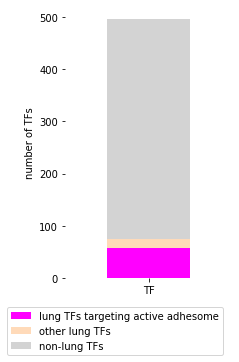

In [24]:
# Barplot
plt.figure()
htargettf_df.sort_values('category_id').drop_duplicates(subset=['TF'], keep='first').groupby('category').nunique()[['TF']].loc[['lung TFs targeting active adhesome','other lung TFs','non-lung TFs']].T.plot.bar(stacked=True, color=['magenta','peachpuff','lightgrey'], rot=0, figsize=(3,5))
sns.despine(left=True, bottom=True, right=True)
plt.ylabel('number of TFs')
plt.legend(loc='lower center', bbox_to_anchor=(0.3,-0.3))
plt.show()

##### Adhesome genes targeted by TFs

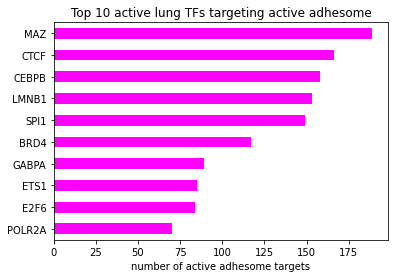

In [27]:
# Barplot of adhesome TFs
adhesome_lung_htargettf_df = htargettf_df[(htargettf_df['lung']==True) & 
                                          (htargettf_df['active adhesome target']==True) &
                                          (htargettf_df['active TF']==True)]
plt.figure()
adhesome_lung_htargettf_df.groupby(['TF']).nunique()['target'].sort_values(ascending=True)[-10:].plot.barh(color='magenta')
plt.xlabel('number of active adhesome targets')
plt.ylabel('')
plt.title('Top 10 active lung TFs targeting active adhesome')
plt.show()

In [16]:
# Define all tissues available
all_tissues = list(itertools.chain.from_iterable((htargettf_df['tissue'].str.lower().str.split(',')).values))
# Only keep unique tissues
all_tissues = np.unique(all_tissues)
# Remove irrelevant entries
all_tissues = np.delete(all_tissues,
                        np.where((all_tissues=='other') | (all_tissues=='unknown') | (all_tissues=='unclear'))[0])

In [17]:
# Obtain proportion of genome/adhesome targets or each adhesome TF in all tissues
prop_dataframes = []
for tissue in tqdm(all_tissues):
    # Obtain proportion of genome targets or each adhesome TF
    adhesome_htargettf_df = htargettf_df[(htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)) &
                                         (htargettf_df['tissue'].str.lower().str.contains(tissue))]
    prop_genome_df = (adhesome_htargettf_df[adhesome_htargettf_df['active target']==True].groupby(['TF'])
                      ['target'].nunique()/len(active_genes)).reset_index().set_index('TF')
    prop_genome_df.columns = ['prop_genome_targets_'+tissue]
    # Obtain proportion of adhesome targets or each adhesome TF
    prop_adhesome_df = (adhesome_htargettf_df[adhesome_htargettf_df['active adhesome target']==True].groupby(['TF'])
                        ['target'].nunique()/len(active_adhesome_genes)).reset_index().set_index('TF')
    prop_adhesome_df.columns = ['prop_adhesome_targets_'+tissue]
    # Combine to dataframe
    tf_char_df = prop_genome_df.join(prop_adhesome_df, how='outer')
    prop_dataframes.append(tf_char_df)
tf_char_df = pd.concat(prop_dataframes, axis=1)
#tf_char_df = tf_char_df.fillna(0)

100%|██████████| 96/96 [01:14<00:00,  1.28it/s]


In [18]:
# Hypergeometric confidence interval

# Hypergeometric parameters N and K
N = len(active_genes) # total number of active genes
K = len(active_adhesome_genes) # total number of active adhesome genes

# Sequence of hyper geometric parameter n
q_list = np.logspace(-4,0,1000)
n_list = [int(q*N) for q in q_list]

# Lower and upper bound of (right-sided) CI
alpha = 0.05/len(active_lung_adhesome_tf_genes) # level of confidence interval
ci_lowerbound = np.repeat(0, len(q_list))
ci_upperbound = np.array([ss.hypergeom.ppf(1-alpha, N, K, n, loc=0) for n in n_list])/K

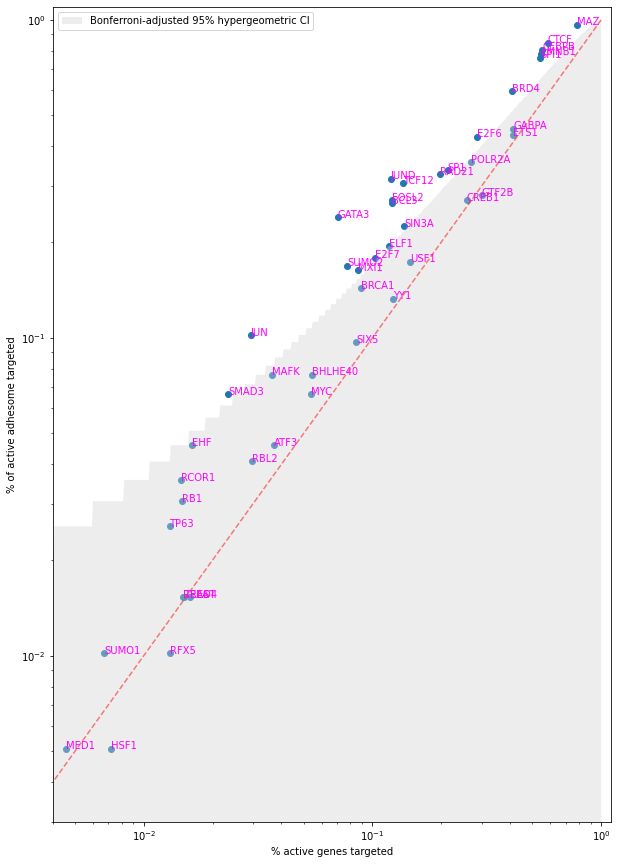

In [19]:
# Plot TFs on prop_genome_targets - prop_adhesome_targets space
fig, ax = plt.subplots(figsize=(10,15))
x = tf_char_df['prop_genome_targets_lung']
y = tf_char_df['prop_adhesome_targets_lung']
labels = tf_char_df.index.values
ax.scatter(x, y)
ax.plot((0,1),(0,1), color='red', linestyle='dashed', alpha=0.5)
ax.fill_between(q_list, ci_lowerbound, ci_upperbound, where=None, facecolor='lightgrey', 
                interpolate=False, alpha=0.4, label='Bonferroni-adjusted 95% hypergeometric CI')
for i in range(tf_char_df.shape[0]):
    ax.annotate(labels[i], (x[i], y[i]), size=10, color='magenta')
plt.xlabel('% active genes targeted')
plt.ylabel('% of active adhesome targeted')
plt.legend(loc='upper left')
plt.xscale('log')
plt.yscale('log')
plt.xlim([4e-3,1.1])
plt.ylim([3e-3,1.1])
plt.show()

In [20]:
for tissue in tqdm(all_tissues):
    pvals = [ss.hypergeom.sf(tf_char_df.loc[tf,'prop_adhesome_targets_'+tissue]*K, 
                             N, 
                             K, 
                             tf_char_df.loc[tf,'prop_genome_targets_'+tissue]*N)*len(active_lung_adhesome_tf_genes)
             for tf in tf_char_df.index]
    tf_char_df = pd.concat(
        [tf_char_df, pd.DataFrame({'adj_pval_'+tissue: pvals}, index=tf_char_df.index)], 
        axis=1
    )
    tf_char_df['adj_pval_'+tissue] = tf_char_df['adj_pval_'+tissue].fillna(1)

100%|██████████| 96/96 [00:00<00:00, 122.80it/s]


In [21]:
# Determine number of significant TFs for all tissues
significant_tf_per_tissue_df = tf_char_df.loc[:,[col for col in tf_char_df.columns if ('adj_pval' in col)]].T
significant_tf_per_tissue_df.index = significant_tf_per_tissue_df.index.str.replace('adj_pval_','')
significant_tf_per_tissue_df = (significant_tf_per_tissue_df<0.05).astype(int)
significant_tf_per_tissue_df = significant_tf_per_tissue_df.sum(axis=1).reset_index()
significant_tf_per_tissue_df.columns = ['tissue', 'number of significant lung adhesome TFs']
significant_tf_per_tissue_df = significant_tf_per_tissue_df.set_index('tissue')

In [22]:
# Determine number of adhesome TFs present for all tissues
n_tf_per_tissue_df = tf_char_df.loc[:,[col for col in tf_char_df.columns if ('prop_genome_targets' in col)]].T
n_tf_per_tissue_df.index = n_tf_per_tissue_df.index.str.replace('prop_genome_targets_','')
n_tf_per_tissue_df = (~n_tf_per_tissue_df.isna()).astype(int)
n_tf_per_tissue_df = n_tf_per_tissue_df.sum(axis=1).reset_index()
n_tf_per_tissue_df.columns = ['tissue', 'number of lung adhesome TFs present']
n_tf_per_tissue_df = n_tf_per_tissue_df.set_index('tissue')

In [23]:
# Combine dataframes
tf_per_tissue_df = pd.concat([significant_tf_per_tissue_df, n_tf_per_tissue_df], axis=1)
tf_per_tissue_df = tf_per_tissue_df.sort_values(by=['number of significant lung adhesome TFs',
                                                    'number of lung adhesome TFs present'])

<Figure size 432x288 with 0 Axes>

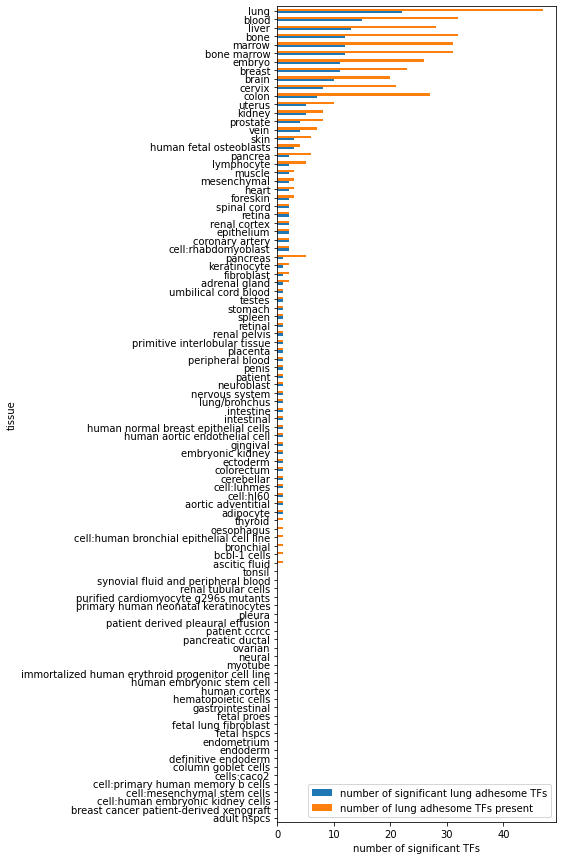

In [24]:
# Plot number of significant TFs for all tissues
plt.figure()
tf_per_tissue_df[['number of significant lung adhesome TFs', 
                  'number of lung adhesome TFs present']].plot.barh(figsize=(5,15))
plt.legend(loc='lower right')
plt.xlabel('number of significant TFs')
plt.ylabel('tissue')
plt.show()

In [25]:
len(tf_char_df[tf_char_df['adj_pval_lung']<0.05])

22

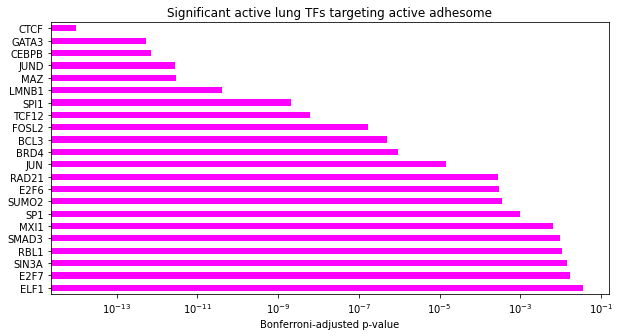

In [26]:
# Barplot of significant adhesome TFs
tf_char_df = tf_char_df.sort_values(by='adj_pval_lung', ascending=False)
plt.figure(figsize=(10,5))
tf_char_df[tf_char_df['adj_pval_lung']<0.05]['adj_pval_lung'].plot.barh(color='magenta')
plt.xscale('log')
plt.xlabel('Bonferroni-adjusted p-value')
plt.ylabel('')
plt.title('Significant active lung TFs targeting active adhesome')
plt.show()
significant_tfs = tf_char_df[tf_char_df['adj_pval_lung']<0.05].index.values

# Number of interactions involving adhesome genes in all tissues

In [27]:
# Create data frame of TF-target in all tissues
htargettf_df2 = htargettf_df.copy()
htargettf_df2['tissue'] = htargettf_df2['tissue'].str.lower()
htargettf_df2 = htargettf_df2[(htargettf_df2['tissue']!='unclear') & 
                              (htargettf_df2['tissue']!='unknown') & 
                              (htargettf_df2['tissue']!='other')]
htargettf_df2['tissue'] = htargettf_df2['tissue'].str.split(',')
htargettf_df2 = lu.unnesting(htargettf_df2, ['tissue'])

In [28]:
htargettf_df2

,tissue,TF,active TF,target,active target,adhesome target,active adhesome target,lung,category,category_id
0,colon,AEBP2,True,TMEM53,True,False,False,False,non-lung TFs,3
1,colon,AEBP2,True,C1orf228,False,False,False,False,non-lung TFs,3
2,colon,AEBP2,True,FBXO31,True,False,False,False,non-lung TFs,3
3,colon,AEBP2,True,ADAMTSL5,True,False,False,False,non-lung TFs,3
4,colon,AEBP2,True,CTB-25B13.9,False,False,False,False,non-lung TFs,3
...,...,...,...,...,...,...,...,...,...,...
1342105,cervix,ZZZ3,False,ZBTB20,True,False,False,False,non-lung TFs,3
1342106,cervix,ZZZ3,False,FAIM,True,False,False,False,non-lung TFs,3
1342106,blood,ZZZ3,False,FAIM,True,False,False,False,non-lung TFs,3
1342108,cervix,ZZZ3,False,SSBP3,True,False,False,False,non-lung TFs,3


In [29]:
# Compute number of genes targeted in all tissues
htargettf_df2_all = htargettf_df2.groupby('tissue')['target'].nunique()
htargettf_df2_all = htargettf_df2_all.reset_index()
htargettf_df2_all.columns = ['tissue', 'number of genes targeted']
htargettf_df2_all = htargettf_df2_all.set_index('tissue')
htargettf_df2_all = htargettf_df2_all.sort_values(by='number of genes targeted')

In [30]:
# Compute number of adhesome genes targeted in all tissues
htargettf_df2_adh = htargettf_df2[htargettf_df2['adhesome target']==True]
htargettf_df2_adh = htargettf_df2_adh.groupby('tissue')['target'].nunique()
htargettf_df2_adh = htargettf_df2_adh.reset_index()
htargettf_df2_adh.columns = ['tissue', 'number of adhesome genes targeted']
htargettf_df2_adh = htargettf_df2_adh.set_index('tissue')
htargettf_df2_adh = htargettf_df2_adh.sort_values(by='number of adhesome genes targeted')

In [31]:
# Join
targets_per_tissues = pd.concat([htargettf_df2_all, htargettf_df2_adh], axis=1)
targets_per_tissues = targets_per_tissues.fillna(0).astype(int)

In [32]:
targets_per_tissues

,number of genes targeted,number of adhesome genes targeted
tissue,,
synovial fluid and peripheral blood,4,0
cell:primary human memory b cells,10,0
neural,12,0
fetal lung fibroblast,28,1
column goblet cells,33,1
...,...,...
embryo,29329,218
bone marrow,30331,217
blood,32358,220


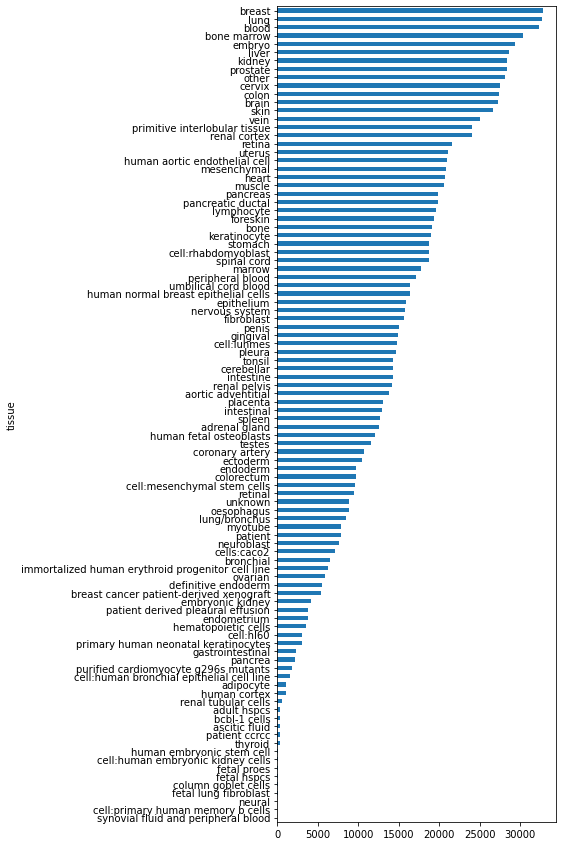

In [33]:
# Plot number of adhesome genes targeted for each tissue
plt.figure()
targets_per_tissues['number of genes targeted'].plot.barh(figsize=(5,15))
plt.show()

In [34]:
targets_per_tissues['number of adhesome genes targeted']/targets_per_tissues['number of genes targeted']

tissue
synovial fluid and peripheral blood    0.000000
cell:primary human memory b cells      0.000000
neural                                 0.000000
fetal lung fibroblast                  0.035714
column goblet cells                    0.030303
                                         ...   
embryo                                 0.007433
bone marrow                            0.007154
blood                                  0.006799
lung                                   0.006660
breast                                 0.006668
Length: 98, dtype: float64

# TF network

In [81]:
# Obtain TF network for the adhesome
tf_edgelist_lung = htargettf_df[htargettf_df['tissue']=='lung']
tf_edgelist_lung = tf_edgelist_lung[(tf_edgelist_lung['TF'].isin(active_lung_adhesome_tf_genes)) & 
                                    (tf_edgelist_lung['target'].isin(active_lung_adhesome_tf_genes))]
tf_edgelist_lung = tf_edgelist_lung[['TF','target']]
tf_edgelist_lung.columns = ['source', 'target']
G_lung = nx.from_pandas_edgelist(tf_edgelist_lung)
tf_net_summary = pd.DataFrame({'tissue': [tissue],
                               'number of TFs': [len(G_lung.nodes)],
                               'number of edges': [len(G_lung.edges)],
                               'density': [nx.density(G_lung)]})
oi.output_networkx_graph_as_interactive_html(G_lung, 'test.html')

PosixPath('/home/louiscam/projects/gpcr/code/figures4/graph.html')

In [82]:
# Compute metrics of adhesome TF networks in all tissues
for tissue in tqdm(all_tissues):
    adhesome_tf_genes = htargettf_df[(htargettf_df['tissue'].str.contains('lung')) & 
                                     (htargettf_df['adhesome target']==True)]['TF'].unique()
    tf_edgelist = htargettf_df[htargettf_df['tissue'].str.contains(tissue)]
    tf_edgelist = tf_edgelist[(tf_edgelist['TF'].isin(adhesome_tf_genes)) & 
                              (tf_edgelist['target'].isin(adhesome_tf_genes))]
    tf_edgelist = tf_edgelist[['TF','target']]
    tf_edgelist.columns = ['source', 'target']
    G = nx.from_pandas_edgelist(tf_edgelist)
    tf_net_tissue = pd.DataFrame({'tissue': [tissue],
                                  'number of TFs': [len(G.nodes)],
                                  'number of edges': [len(G.edges)],
                                  'density': [nx.density(G)]})
    tf_net_summary = pd.concat([tf_net_summary, tf_net_tissue], axis=0)
    
tf_net_summary = tf_net_summary.set_index('tissue')

100%|██████████| 96/96 [01:20<00:00,  1.20it/s]


In [95]:
tf_net_summary.loc[['blood','lung','liver','breast', 'bone marrow', 'skin']]

,number of TFs,number of edges,density
tissue,,,
blood,54,598,0.417890
lung,58,753,0.455535
liver,56,534,0.346753
breast,55,483,0.325253
bone marrow,54,536,0.374563
skin,52,143,0.107843


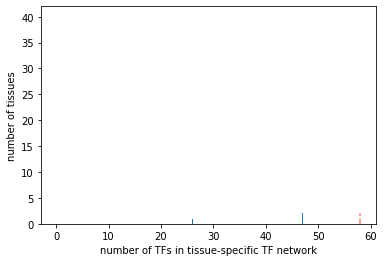

In [87]:
# Compare metrics
plt.figure()
plt.hist(tf_net_summary['number of TFs'].values, bins=np.arange(0,tf_net_summary['number of TFs'].max()+0.1,0.02))
plt.vlines(x=tf_net_summary.loc['lung']['number of TFs'], ymin=0, ymax=40, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('number of TFs in tissue-specific TF network')
plt.ylabel('number of tissues')
plt.show()

In [89]:
tf_net_summary['number of TFs'].max()

58

In [55]:
htargettf_df

,TF,active TF,target,active target,adhesome target,active adhesome target,tissue,lung,category,category_id
0,AEBP2,True,TMEM53,True,False,False,colon,False,non-lung TFs,3
1,AEBP2,True,C1orf228,False,False,False,colon,False,non-lung TFs,3
2,AEBP2,True,FBXO31,True,False,False,colon,False,non-lung TFs,3
3,AEBP2,True,ADAMTSL5,True,False,False,colon,False,non-lung TFs,3
4,AEBP2,True,CTB-25B13.9,False,False,False,colon,False,non-lung TFs,3
...,...,...,...,...,...,...,...,...,...,...
1342124,CCDC101,True,CLN3,True,False,False,unclear,False,non-lung TFs,3
1342125,CCDC101,True,RP11-666O2.1,False,False,False,unclear,False,non-lung TFs,3
1342126,CCDC101,True,RP11-666O2.2,False,False,False,unclear,False,non-lung TFs,3
1342127,CCDC101,True,RP11-666O2.4,False,False,False,unclear,False,non-lung TFs,3


# Activity of non adhesome targets of adhesome TFs

In [66]:
# Determine the proportion of active adhesome targets among adhesome targets for each TF (in the lung)
n_adhtarget_per_tf = adhesome_htargettf_df[
    adhesome_htargettf_df['adhesome target']==True
].groupby('TF')['target'].size()
n_active_adhtarget_per_tf = adhesome_htargettf_df[
    adhesome_htargettf_df['active adhesome target']==True
].groupby('TF')['target'].size()
tf_char_df['active_adh_target_prop'] = n_active_adhtarget_per_tf/n_adhtarget_per_tf

In [67]:
# Determine the proportion of active lung non adhesome targets among all non adhesome target for each TF ()
all_adhesome_htargettf_df = htargettf_df[htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)]
n_nonadhtarget_per_tf = all_adhesome_htargettf_df[
    all_adhesome_htargettf_df['adhesome target']==False
].groupby('TF')['target'].size()
n_active_lung_nonadhtarget_per_tf = adhesome_htargettf_df[
    (adhesome_htargettf_df['adhesome target']==False) & (adhesome_htargettf_df['active target']==True)
].groupby('TF')['target'].size()
tf_char_df['active_nonadh_target_prop'] = n_active_lung_nonadhtarget_per_tf/n_nonadhtarget_per_tf

In [68]:
# Number of active adhesome targets in the lung 
adh_active_lung_targets_perTF = htargettf_df[(htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)) &
                                 (htargettf_df['lung']==True) &
                                 (htargettf_df['active adhesome target']==True)].groupby('TF')['target'].nunique()
tf_char_df['active_adh_target_size'] = adh_active_lung_targets_perTF

In [69]:
# Proportion of active non-adhesome targets out of all non-adhesome targets of adhesome TFs
n_nonadh_lung_targets = adhesome_htargettf_df[~adhesome_htargettf_df['target'].isin(active_adhesome_genes)]['target'].nunique()
n_nonadh_targets = htargettf_df[(htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)) &
                                (htargettf_df['adhesome target']==False)]['target'].nunique()
n_nonadh_active_lung_targets = adhesome_htargettf_df[(~adhesome_htargettf_df['target'].isin(active_adhesome_genes)) &
                                         (adhesome_htargettf_df['active target']==True)]['target'].nunique()
alpha = n_nonadh_active_lung_targets/n_nonadh_targets


In [70]:
# Proportion of active lung targets out of all adhesome gene targets
n_adh_targets = htargettf_df[(htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)) &
                             (htargettf_df['adhesome target']==True)]['target'].nunique()
n_adh_active_lung_targets = htargettf_df[(htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)) &
                                         (htargettf_df['lung']==True) &
                                         (htargettf_df['active adhesome target']==True)]['target'].nunique()
beta = n_adh_active_lung_targets/n_adh_targets

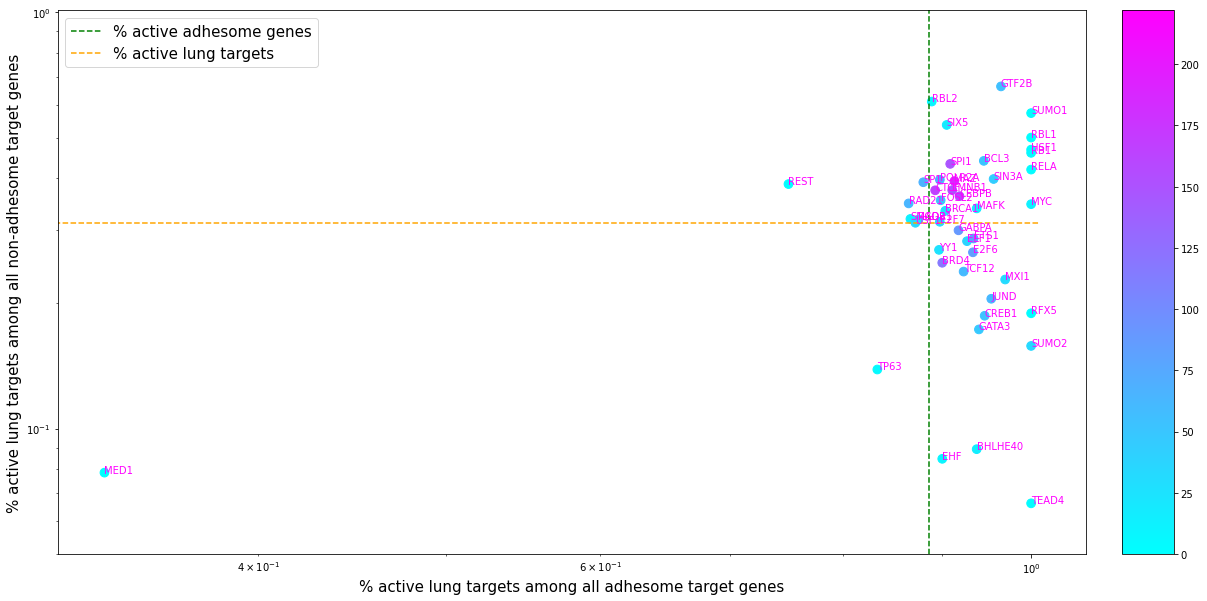

In [115]:
# Plot TFs on active_adh_target_prop - active_nonadh_target_prop space
fig, ax = plt.subplots(figsize=(20,10))
x = tf_char_df['active_adh_target_prop']
y = tf_char_df['active_nonadh_target_prop']
z = tf_char_df['active_adh_target_size']
labels = tf_char_df.index.values

ax.plot((beta,beta), (0,1.01), color='green', linestyle='dashed', alpha=1, label='% active adhesome genes')
ax.plot((0,1.01), (alpha,alpha), color='orange', linestyle='dashed', alpha=1, label='% active lung targets')
scat = ax.scatter(x, y, c=z, cmap='cool', s=75, vmin=0, vmax=222)
for i in range(tf_char_df.shape[0]):
    ax.annotate(labels[i], (x[i], y[i]), size=10, color='magenta')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
fig.colorbar(scat, cax=cax, orientation='vertical')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([0.74,1.01])
ax.set_ylim([5e-2,1.01])
ax.set_xlabel('% active lung targets among all adhesome target genes', fontsize=15)
ax.set_ylabel('% active lung targets among all non-adhesome target genes', fontsize=15)
ax.legend(loc='upper left', fontsize=15)
plt.show()